In [1]:
# Name: Kuan-Te Lee
# Github Username: kuantele
# USC ID: 9485847172
import logging, os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from skimage import io
import warnings
import random
logging.getLogger('tensorflow').disabled = True
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from PIL import Image 
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16

warnings.filterwarnings("ignore")
logging.disable(logging.WARNING)

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=2048)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('../data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [4]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('../train_source_images.txt')
validate_ids = load_text_ids('../val_source_images.txt')
test_ids = load_text_ids('../test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# Loading and pre processing the data
### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [5]:
def load_and_preprocess(img_loc, label):
    def _inner_function(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        
        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')
        
        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])
        
        # Normalize the image to the [0, 1] range
        img = img / 255.0

        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        
        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    
    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    y.set_shape([])  # Scalar label
    
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 


In [6]:
# for batch in tf_dataset_train:
#     img_data, labels = batch
#     # Process img_data and labels as needed
#     print("Image data shape:", img_data.shape)
#     print("Labels shape:", labels.shape)
#     break

# Data augmentation layers
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.1),
    preprocessing.RandomContrast(0.1),
    preprocessing.RandomTranslation(0.1, 0.1)
])

def apply_augmentation(image, label):
    return data_augmentation(image), label

# Apply data augmentation to the dataset
tf_dataset_train_augmented = tf_dataset_train.map(apply_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [7]:
def create_model(input_shape):
    model = models.Sequential()
    
    # Convolutional layers
    model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten layer
    model.add(layers.Flatten())
    
    # Dense layer with dropout and L2 regularization
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(10)))
    model.add(layers.Dropout(0.3))
    
    # Output layer
    model.add(layers.Dense(2, activation='softmax'))
    
    return model

print("1. (c) ii")
# Define constants
input_shape = (299, 299, 3) 
num_classes = 2 
epochs = 20

# Create the model
model = create_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(tf_dataset_train_augmented, epochs=epochs, validation_data=tf_dataset_val, callbacks=[early_stopping])

# # Plot training and validation accuracy
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# Evaluate the model on the test set
# test_loss, test_acc = model.evaluate(tf_dataset_test)
# print(f'Test Accuracy: {test_acc}')

1. (c) ii
Epoch 1/20
928/928 [==============================] - 1047s 1s/step - loss: 21.4051 - accuracy: 0.5894 - val_loss: 4.7089 - val_accuracy: 0.8279
Epoch 2/20
928/928 [==============================] - 773s 831ms/step - loss: 2.5028 - accuracy: 0.6938 - val_loss: 2.2590 - val_accuracy: 0.3328
Epoch 3/20
928/928 [==============================] - 701s 752ms/step - loss: 1.8140 - accuracy: 0.7450 - val_loss: 5.1764 - val_accuracy: 0.3250
Epoch 4/20
928/928 [==============================] - 707s 760ms/step - loss: 1.8828 - accuracy: 0.7749 - val_loss: 1.6488 - val_accuracy: 0.6823
Epoch 5/20
928/928 [==============================] - 738s 792ms/step - loss: 2.0681 - accuracy: 0.7913 - val_loss: 3.4058 - val_accuracy: 0.3331
Epoch 6/20
928/928 [==============================] - 749s 804ms/step - loss: 2.1817 - accuracy: 0.8079 - val_loss: 4.2697 - val_accuracy: 0.3416
Epoch 7/20
928/928 [==============================] - 680s 730ms/step - loss: 1.9423 - accuracy: 0.8187 - val_loss:

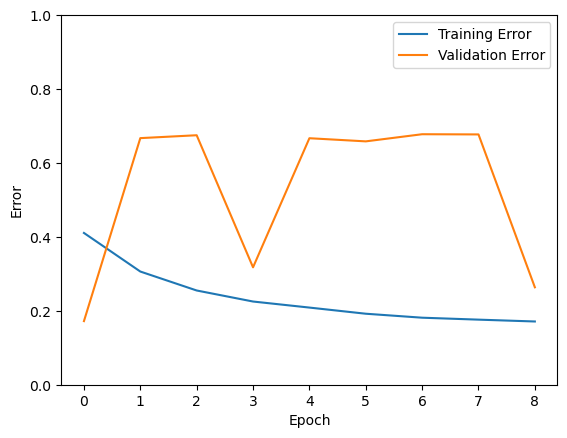

In [8]:
# Plot training and validation errors
training_Error = [1 - value for value in history.history['accuracy']]
validation_Error = [1 - value for value in history.history['val_accuracy']]

plt.plot(training_Error, label='Training Error')
plt.plot(validation_Error, label='Validation Error')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

In [9]:
print("1. (c) iii")

from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming tf_dataset_test is your test dataset
y_true = []  # True labels
y_pred = []  # Predicted labels

# Iterate over the test dataset and make predictions
for images, labels in tf_dataset_test:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

1. (c) iii
1/1 [==============================] - 0s 47ms/step
Precision: 0.6977
Recall: 0.7490
F1 Score: 0.7224


In [9]:
def load_and_preprocess2(img_loc, label):
    def _inner_function2(img_loc, label):
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        
        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')
        
        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [224, 224])
        
        # Normalize the image to the [0, 1] range
        img = img / 255.0

        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        
        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function2, [img_loc, label], [tf.float32, tf.int64])
    
    # Set the shape of the tensors
    X.set_shape([224, 224, 3])
    y.set_shape([])  # Scalar label
    
    return X, y

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

In [48]:
batch_sized = 5

img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_traind = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_traind = tf_dataset_traind.map(load_and_preprocess2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_traind = tf_dataset_traind.shuffle(buffer_size=buffer_size).batch(batch_sized) 

img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_vald = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_vald = tf_dataset_vald.map(load_and_preprocess2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_vald = tf_dataset_vald.shuffle(buffer_size=buffer_size).batch(batch_sized) 

img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_testd = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_testd = tf_dataset_testd.map(load_and_preprocess2, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_testd = tf_dataset_testd.shuffle(buffer_size=buffer_size).batch(batch_sized) 

# Data augmentation layers
data_augmentation2 = tf.keras.Sequential([
    preprocessing.RandomFlip(),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.1),
    preprocessing.RandomContrast(0.1),
    preprocessing.RandomTranslation(0.1, 0.1)
])

def apply_augmentation2(image, label):
    return data_augmentation2(image), label

# Apply data augmentation to the dataset
tf_dataset_train_augmented_d = tf_dataset_traind.map(apply_augmentation2, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [81]:
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.optimizers import Adam

print("1. (d) iii, iv")
# Define the base model
def create_transfer_model(base_model, input_shape):
    base_model.trainable = False

    for layer in base_model.layers:
        if isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
            
    model = models.Sequential([
        base_model,
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.GlobalAveragePooling2D(),
        # layers.Flatten(),
        # layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.1)),
        # layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

# Create EfficientNetB0 model with pre-trained weights
efficientnet_model = EfficientNetB0(weights=None, include_top=False, input_shape=(224, 224, 3))
model_efficientnet = create_transfer_model(efficientnet_model, (224, 224, 3))

# Compile the model
model_efficientnet.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train EfficientNetB0 model
history_efficientnet = model_efficientnet.fit(tf_dataset_train_augmented_d,
                                              epochs=10,
                                              validation_data=tf_dataset_vald,
                                              callbacks=[early_stopping])

1. (d) iii, iv
Epoch 1/10
5936/5936 [==============================] - 816s 136ms/step - loss: 0.3195 - accuracy: 0.9645 - val_loss: 6.1169 - val_accuracy: 0.7149
Epoch 2/10
5936/5936 [==============================] - 887s 149ms/step - loss: 0.1422 - accuracy: 0.9675 - val_loss: 6.1670 - val_accuracy: 0.7003
Epoch 3/10
5936/5936 [==============================] - 1266s 213ms/step - loss: 0.1336 - accuracy: 0.9678 - val_loss: 6.5907 - val_accuracy: 0.7057
Epoch 4/10
5936/5936 [==============================] - 1256s 212ms/step - loss: 0.1343 - accuracy: 0.9670 - val_loss: 2.8744 - val_accuracy: 0.7121
Epoch 5/10
5936/5936 [==============================] - 1255s 211ms/step - loss: 0.1299 - accuracy: 0.9675 - val_loss: 5.0382 - val_accuracy: 0.7110
Epoch 6/10
5936/5936 [==============================] - 1254s 211ms/step - loss: 0.1291 - accuracy: 0.9700 - val_loss: 2.6920 - val_accuracy: 0.7177
Epoch 7/10
5936/5936 [==============================] - 1254s 211ms/step - loss: 0.1367 - acc

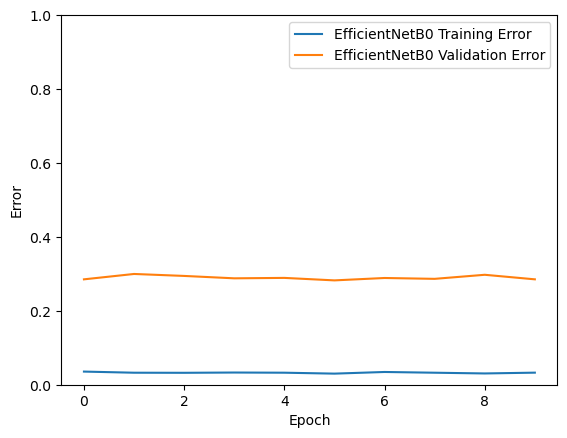

In [82]:
# Plot training and validation errors
training_Error = [1 - value for value in history_efficientnet.history['accuracy']]
validation_Error = [1 - value for value in history_efficientnet.history['val_accuracy']]

plt.plot(training_Error, label='EfficientNetB0 Training Error')
plt.plot(validation_Error, label='EfficientNetB0 Validation Error')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

In [89]:
y_true = []  # True labels
y_pred_eff = []  # Predicted labels

# Iterate over the test dataset and make predictions
for images, labels in tf_dataset_testd:
    predictions = model_efficientnet.predict(images)
    binary_predictions = (predictions[:] > 0.5).astype(int)
    y_true.extend(labels.numpy())
    y_pred_eff.extend(binary_predictions.tolist())

# Calculate precision, recall, and F1 score
precision_eff = precision_score(y_true, y_pred_eff)
recall_eff = recall_score(y_true, y_pred_eff)
f1_eff = f1_score(y_true, y_pred_eff)

print(f'Precision for EfficientNetB0: {precision_eff:.4f}')
print(f'Recall for EfficientNetB0: {recall_eff:.4f}')
print(f'F1 Score for EfficientNetB0: {f1_eff:.4f}')

1/1 [==============================] - 0s 76ms/step
Precision for EfficientNetB0: 0.8519
Recall for EfficientNetB0: 0.4290
F1 Score for EfficientNetB0: 0.5707


In [19]:
batch_sized = 5

img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_traind = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_traind = tf_dataset_traind.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_traind = tf_dataset_traind.shuffle(buffer_size=buffer_size).batch(batch_sized) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_vald = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_vald = tf_dataset_vald.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_vald = tf_dataset_vald.shuffle(buffer_size=buffer_size).batch(batch_sized) 

img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_testd = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_testd = tf_dataset_testd.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_testd = tf_dataset_testd.shuffle(buffer_size=buffer_size).batch(batch_sized) 

# Apply data augmentation to the dataset
tf_dataset_train_augmented_d = tf_dataset_traind.map(apply_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [9]:
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from tensorflow.keras.optimizers import Adam

# Define the base model
def create_transfer_model2(base_model, input_shape):
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        # layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        # layers.BatchNormalization(),
        # layers.Dropout(0.3),
        layers.Dense(2, activation='softmax')
    ])

    return model

# Create ResNet50, model with pre-trained weights
resNet_model = ResNet50(include_top=False, input_shape=(299, 299, 3))
model_resNet = create_transfer_model2(resNet_model, (299, 299, 3))

# Compile the model
model_resNet.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train EfficientNetB0 model
history_resNet = model_resNet.fit(tf_dataset_train_augmented_d,
                                              epochs=10,
                                              validation_data=tf_dataset_vald,
                                              callbacks=[early_stopping])

Epoch 1/10
5936/5936 [==============================] - 1849s 311ms/step - loss: 0.7587 - accuracy: 0.7227 - val_loss: 0.8379 - val_accuracy: 0.5439
Epoch 2/10
5936/5936 [==============================] - 1750s 294ms/step - loss: 0.4885 - accuracy: 0.7595 - val_loss: 0.9776 - val_accuracy: 0.5058
Epoch 3/10
5936/5936 [==============================] - 1752s 295ms/step - loss: 0.4581 - accuracy: 0.7810 - val_loss: 1.1982 - val_accuracy: 0.4539
Epoch 4/10
5936/5936 [==============================] - 1944s 327ms/step - loss: 0.4381 - accuracy: 0.7937 - val_loss: 1.0086 - val_accuracy: 0.6104
Epoch 5/10
5936/5936 [==============================] - 1487s 250ms/step - loss: 0.4318 - accuracy: 0.7968 - val_loss: 1.0036 - val_accuracy: 0.5915
Epoch 6/10
5936/5936 [==============================] - 1696s 286ms/step - loss: 0.4244 - accuracy: 0.8005 - val_loss: 0.7829 - val_accuracy: 0.6768
Epoch 7/10
5936/5936 [==============================] - 1616s 272ms/step - loss: 0.4209 - accuracy: 0.8046

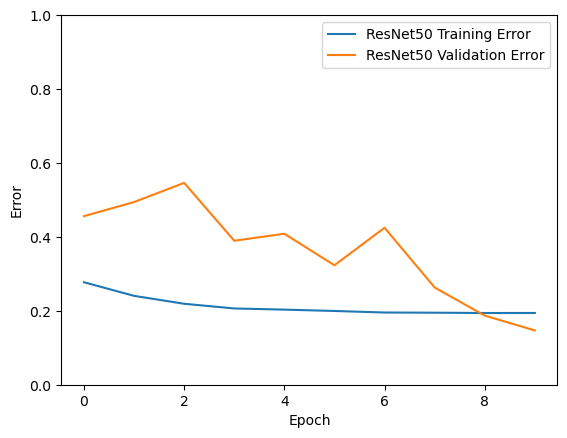

In [10]:
training_Error = [1 - value for value in history_resNet.history['accuracy']]
validation_Error = [1 - value for value in history_resNet.history['val_accuracy']]

plt.plot(training_Error, label='ResNet50 Training Error')
plt.plot(validation_Error, label='ResNet50 Validation Error')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

In [11]:
y_true = []  # True labels
y_pred_res = [] # Predicted labels

# Iterate over the test dataset and make predictions
for images, labels in tf_dataset_testd:
    predictions = model_resNet.predict(images)
    y_true.extend(labels.numpy())
    y_pred_res.extend(tf.argmax(predictions, axis=1).numpy())

# Calculate precision, recall, and F1 score
precision_res = precision_score(y_true, y_pred_res)
recall_res = recall_score(y_true, y_pred_res)
f1_res = f1_score(y_true, y_pred_res)

print(f'Precision for ResNet50,: {precision_res:.4f}')
print(f'Recall for ResNet50,: {recall_res:.4f}')
print(f'F1 Score for ResNet50,: {f1_res:.4f}')

1/1 [==============================] - 1s 897ms/step
Precision for ResNet50,: 0.8898
Recall for ResNet50,: 0.6261
F1 Score for ResNet50,: 0.7350


In [21]:
# Define the base model
def create_transfer_model3(base_model, input_shape):
    base_model.trainable = False
    
    model = models.Sequential([
        base_model,
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])

    return model


# Create VGG16, model with pre-trained weights
vgg_model = VGG16(include_top=False, input_shape=(299, 299, 3))
model_vgg = create_transfer_model3(vgg_model, (299, 299, 3))

# Compile the model
model_vgg.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train EfficientNetB0 model
history_vgg = model_vgg.fit(tf_dataset_train_augmented_d,
                                              epochs=10,
                                              validation_data=tf_dataset_vald,
                                              callbacks=[early_stopping])

Epoch 1/10
5936/5936 [==============================] - 2068s 348ms/step - loss: 0.2409 - accuracy: 0.9022 - val_loss: 1.1128 - val_accuracy: 0.7593
Epoch 2/10
5936/5936 [==============================] - 2078s 350ms/step - loss: 0.1481 - accuracy: 0.9417 - val_loss: 1.5340 - val_accuracy: 0.7375
Epoch 3/10
5936/5936 [==============================] - 2228s 375ms/step - loss: 0.1177 - accuracy: 0.9542 - val_loss: 1.4870 - val_accuracy: 0.7694
Epoch 4/10
5936/5936 [==============================] - 3034s 511ms/step - loss: 0.1039 - accuracy: 0.9616 - val_loss: 1.5466 - val_accuracy: 0.7557
Epoch 5/10
5936/5936 [==============================] - 2016s 340ms/step - loss: 0.0926 - accuracy: 0.9652 - val_loss: 1.7765 - val_accuracy: 0.7683
Epoch 6/10
5936/5936 [==============================] - 2866s 483ms/step - loss: 0.0847 - accuracy: 0.9683 - val_loss: 1.3395 - val_accuracy: 0.8147


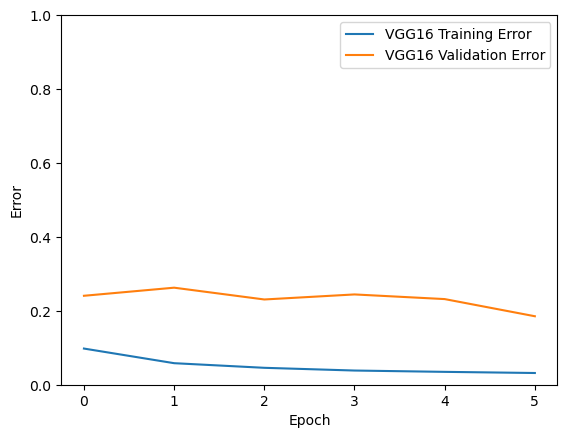

In [22]:
# Plot training and validation errors
training_Error = [1 - value for value in history_vgg.history['accuracy']]
validation_Error = [1 - value for value in history_vgg.history['val_accuracy']]

plt.plot(training_Error, label='VGG16 Training Error')
plt.plot(validation_Error, label='VGG16 Validation Error')
plt.ylim(0, 1)
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()

In [23]:
y_true = []  # True labels
y_pred_vgg = [] # Predicted labels

# Iterate over the test dataset and make predictions
for images, labels in tf_dataset_testd:
    predictions = model_vgg.predict(images)
    y_true.extend(labels.numpy())
    y_pred_vgg.extend(tf.argmax(predictions, axis=1).numpy())

# Calculate precision, recall, and F1 score
precision_vgg = precision_score(y_true, y_pred_vgg)
recall_vgg = recall_score(y_true, y_pred_vgg)
f1_vgg = f1_score(y_true, y_pred_vgg)

print(f'Precision for VGG16: {precision_vgg:.4f}')
print(f'Recall for VGG16: {recall_vgg:.4f}')
print(f'F1 Score for VGG16: {f1_vgg:.4f}')

1/1 [==============================] - 16s 16s/step
Precision for VGG16: 0.9665
Recall for VGG16: 0.8858
F1 Score for VGG16: 0.9244


1. (d) vi

The VGG16 is the best model for this project in my case. This model is also good at generalization.

The results for CNN + MLP and ResNet50 are quite similar. 

I spend most of the time training EfficientNetB0, and try tens of parameter combinations. This parameter is the only way I made my model not just predict 0 or 1. Therefore, I think the EfficientNetB0 model is unsuitable for this project.
